In [1]:
#!pip uninstall tensorflow

In [2]:
#!pip install tensorflow-gpu==2.0.0

In [1]:
from tensorflow.compat.v1 import enable_eager_execution
import tensorflow as tf
import numpy as np
import os
import tensorflow_probability as tfp
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score
import random
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skopt import gp_minimize #貝氏優化
from skopt.space import Real, Integer
from skopt.utils import use_named_args

print(tf.__version__)

2.0.0


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)

## 匯入資料（MNIST）

## 參數設定

In [3]:
img_size = 28
flatten_size = img_size * img_size 

regular = 1e-5

z_dim = 32
h_dim = [8, 4]
objective = 'deep-SVDD'     #'  'soft-boundary'


## 建構模型

## Prtrain

In [4]:
class Autoencoder():
    
    def __init__(self, label_num, img_size = 28, z_dim = 32, h_dim = [8, 4]):
        
        self.label_num = label_num
        self.img_size = img_size
        self.flatten_size = img_size * img_size
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.ae_optimizer = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 0.5e-3)
        

    def make_encoder(self):

        inputs = tf.keras.Input(shape=(self.flatten_size,), name='inputs')
        x = tf.reshape(inputs, shape = (-1, self.img_size, self.img_size, 1))
        x = tf.keras.layers.Conv2D(self.h_dim[0], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(self.h_dim[1], (5, 5), activation='linear', padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization(epsilon = 1e-04)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Flatten(name = 'Flatten')(x)    
        x = tf.keras.layers.Dense(self.z_dim, use_bias = False, name = 'dense')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model    
   
    def make_decoder(self):

        inputs = tf.keras.Input(shape=(self.z_dim,), name='inputs')
        x = tf.keras.layers.Dense(self.h_dim[1] * 7 * 7,  use_bias = False)(inputs)
        x = tf.reshape(x, shape = (-1, 7, 7, self.h_dim[1]))
        x = tf.keras.layers.LeakyReLU()(x)
        #x = tf.keras.layers.UpSampling2D((2, 2))(x)    

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[1], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)   

        x = tf.keras.layers.Conv2DTranspose(self.h_dim[0], (5, 5), padding='same',  use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x) 

        x = tf.keras.layers.Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same',  use_bias = False)(x)

        x = tf.reshape(x, shape = (-1, self.flatten_size))
        model = tf.keras.Model(inputs=inputs, outputs=x)

        return model   
    
    @tf.function
    def train_ae_model(self, batch_x):
        with tf.GradientTape() as ae_tape:
            ae_output = self.decoder(self.encoder(batch_x, training=True), training=True)
            loss = tf.reduce_mean((ae_output - batch_x) ** 2)

        grads = ae_tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        return loss
    
    def train_ae( self, n_ae_epochs, train_dataset, ae_lr_milestone = 50):
        #loss_list = []
        for epoch in range(n_ae_epochs):
            epoch_ae_loss_avg = tf.metrics.Mean()
            
            if (epoch+1) % ae_lr_milestone == 0:
                self.ae_optimizer.lr = 0.1 * self.ae_optimizer.lr

            for batch, (batch_x, batch_y) in enumerate(train_dataset):

                ae_loss = self.train_ae_model(batch_x)
                #epoch_ae_loss_avg(ae_loss)
            #loss_list.append(epoch_ae_loss_avg.result())
        
        self.encoder.save_weights('D:/7107018014/checkpoint/mnist_classAE_label_{}' .format(
            self.label_num))
        #print('LOSS: {:.4f} '.format(epoch_ae_loss_avg.result()))
        #plt.title('label = {}'.format(self.label_num))
        #plt.plot(loss_list)
        #plt.show()
        

## 匯入資料

In [5]:
def load_data(label_num, outlier_nu):

    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') /255.
    x_test = x_test.astype('float32') /255.
    
    random.seed (1120)
    normal_n = sum(y_train == label_num)
    outlier_n = sum(y_train != label_num)
    indices = np.random.choice(outlier_n, int(normal_n * outlier_nu), replace=False)
    
    x_train = np.vstack( (x_train[y_train==label_num], x_train[y_train!=label_num][indices]))
    y_train = np.hstack( (y_train[y_train==label_num], y_train[y_train!=label_num][indices]))

    # Flatten the dataset
    x_train = x_train.reshape((-1, 28 * 28))
    x_test = x_test.reshape((-1, 28 * 28))
    
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')

    return  x_train, y_train, x_test, y_test

In [6]:
def split_data(x_train, y_train, batch_size = 200):
    x_novali, x_vali, y_novali, y_vali = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
    
    
    n_samples = len(x_novali)
    train_dataset = tf.data.Dataset.from_tensor_slices((x_novali, y_novali))
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)
    
    validation_n = len(x_vali)
    
    return train_dataset, x_novali, y_novali, x_vali, y_vali

## result 

In [7]:
def threshold_img(data, dists):
    dict_score = {}
    for i in range(len(dists)):
        dict_score[float(dists[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [8]:
def threshold_uncertain_img(data, dists, r):
    dist2radius = (dists - r**2)
    normal = dist2radius[dist2radius<0]
    anomaly = dist2radius[dist2radius>0]
    normal_score = {}
    anomaly_score = {}
    for i in range(len(normal)):
        normal_score[float(normal[i])] = i
    for i in range(len(anomaly)):
        anomaly_score[float(anomaly[i])] = i
    normalsort_score = [(k, normal_score[k]) for k in sorted(normal_score.keys())]
    anomalysort_score = [(k, anomaly_score[k]) for k in sorted(anomaly_score.keys())]
    
    n_digits = min([len(normal),len(anomaly),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display normal
        
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[normalsort_score[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[anomalysort_score[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [9]:
def false_img(data, y_test,  dists, r, label_num):
    data_n = data[y_test!=label_num]
    data_p = data[y_test==label_num]
    
    dist_n = (dists - r**2)[y_test!=label_num]
    dist_p = (dists - r**2)[y_test==label_num]
    
    fn = dist_n[dist_n<0]
    fp = dist_p[dist_p>0]
    fn_score = {}
    fp_score = {}
    for i in range(len(fn)):
        fn_score[float(fn[i])] = i
    for i in range(len(fp)):
        fp_score[float(fp[i])] = i
    fn_score_sort = [(k, fn_score[k]) for k in sorted(fn_score.keys())]
    fp_score_sort = [(k, fp_score[k]) for k in sorted(fp_score.keys())]
    n_digits = min([len(fn),len(fp),20])#20  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    #print('normal:', len(normal), 'anomaly', len(anomaly))
    for i in range(1, n_digits):
        # display fn
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data_n[fn_score_sort[-i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # display fp
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data_p[fp_score_sort[i][1]].reshape(img_size, img_size), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
def distance_plot(label_num, dist, name, train = True, label = None,  nu = 0.1):
    treshold = radius_end ** 2
    if train:
        plt.title(str(objective) + ' label = {} train data'.format(name))
        plt.hist(dist[label == label_num], rwidth=0.3, color='b' ,bins = 100,label = 'normal')
        if sum(label!=label_num):
            plt.hist(dist[label != label_num], rwidth = 0.3, color = 'r',label = 'anomaly', bins = 100)
            plt.legend()

        plt.show()       
    
    else:
        plt.title(str(objective) + ' label = {} test data'.format(name))
        plt.hist(dist[label!=label_num], rwidth=0.3, color='r' ,bins = 100,label = 'anomaly')
        plt.hist(dist[label==label_num], rwidth = 0.3, color = 'b',label = 'normal', bins = 100)
        plt.legend()
        plt.show()
    


In [11]:
class make_binary_model():
    def __init__(self, encoder, z_dim = z_dim):
        self.encoder = encoder
        self.z_dim = z_dim
        self.SVDD_model = self.make_model()
    
    
    def initializer(self):
        kernel_initializer = self.encoder.get_layer('dense').get_weights()[0]
        
        return kernel_initializer
    
    def make_model(self):
        
        kernel_initializer = self.initializer()
        
        self.encoder.trainable = True
        x = self.encoder.get_layer('Flatten').output
        x = tf.keras.layers.Dense(
        self.z_dim, activation = 'relu', kernel_initializer = tf.constant_initializer(kernel_initializer))(x)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model_new = tf.keras.Model(inputs = self.encoder.input, outputs = outputs)
    
        return model_new
    
    

In [19]:
class train_classfication():
    
    def __init__(self, label_num , binary_model, train_dataset, nu ):
        
        self.objective = objective
        self.nu = nu
        self.binary_model = binary_model
        self.label_num = label_num
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-4, epsilon = 1e-6)
        self.train_dataset = train_dataset

    def loss(self, batch_x, batch_y):
        
        avg_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=batch_y, logits=batch_x)
        end_loss = tf.reduce_mean(avg_loss)

        return end_loss

    @tf.function
    def train_model(self, batch_x, batch_y):
        with tf.GradientTape() as tape:
            output = self.binary_model(batch_x, training=True)
            output = tf.squeeze(output)
            output_loss = self.loss(output, batch_y)

        grads = tape.gradient(output_loss, self.binary_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.binary_model.trainable_variables))

        return output_loss
    def train( self, lr_milestone):
        
        loss_list = []
        pre_loss = np.inf
        loss = 0.
        for epoch in range(60):
            epoch_ae_loss_avg = tf.metrics.Mean()
            
            if (epoch+1) % lr_milestone == 0:
                self.optimizer.lr = 0.1 * self.optimizer.lr

            for batch, (batch_x, batch_y) in enumerate(train_dataset):

                ae_loss = self.train_model(batch_x, batch_y)
                epoch_ae_loss_avg(ae_loss)
            loss_list.append(epoch_ae_loss_avg.result())
            
        self.binary_model.save_weights('D:/7107018014/checkpoint/binary_model_label_{}_outlier_{}'.format(
            self.label_num, self.nu))                
        plt.plot(loss_list)
        plt.show()
    def score(self, data):
        self.binary_model.load_weights('D:/7107018014/checkpoint/binary_model_label_{}_outlier_{}' .format(
            self.label_num, self.nu))
        output = self.binary_model(data, training = False)
        return output
    
    def train_result(self, x_novali, y_novali, show_img = False, load_model = False):
        
        test_auc = 0.
        confusionmatrix = 0.
        if show_img:
            scores = self.score(x_novali).numpy()
            test_auc, confusionmatrix = self.result(scores, y_novali, radius_end, show_img = show_img)
            distance_plot(self.label_num, dist, self.objective, name =  self.label_num,
                          train = True, label = y_novali, nu = self.nu )
            print(' train label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_novali, dist, radius_end)
            print('train label = {} distance oder'.format(self.label_num))
            threshold_img(x_train, dist)
            
            
        return radius_end, test_auc, confusionmatrix
    
    def result(self, scores, y_test, show_img = False):
        
        y_true = y_test==self.label_num
        test_auc = roc_auc_score(y_true, scores)
        if show_img:
            print('AUC:', test_auc)
            
        return test_auc 
    
    def test_result(self, x_test, y_test, show_img = False, load_model = False, search_u = False):
        
        scores = self.score(x_test).numpy()
        test_auc = self.result(scores, y_test, show_img = show_img)
        if show_img:
            distance_plot(self.label_num, dist, self.objective, name =  self.label_num,
                          train = False, label = y_test, nu = self.nu )
            print('test label = {} uncertain_img'.format(self.label_num))
            threshold_uncertain_img(x_test, dist, radius_end)
            print('test label = {} distance oder'.format(self.label_num))
            threshold_img(x_test, dist)
            
        if search_u:
            print('u = {}, auc = {}'.format(self.nu, test_auc))
        return test_auc

## 看時間的結果

In [20]:
result = np.zeros((10, 4))

Loading  0


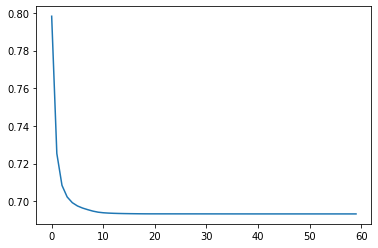

auc =  0.05144650210416761
Loading  1


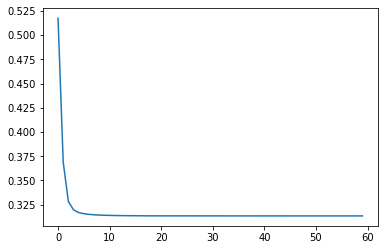

auc =  0.16130280194100943
Loading  2


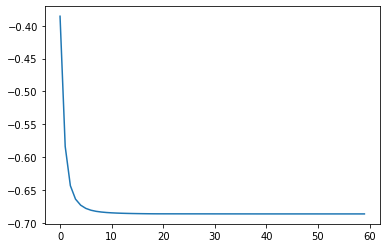

auc =  0.7184143967526226
Loading  3


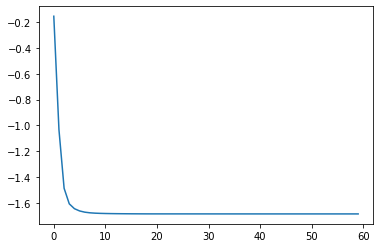

auc =  0.8301055077699093
Loading  4


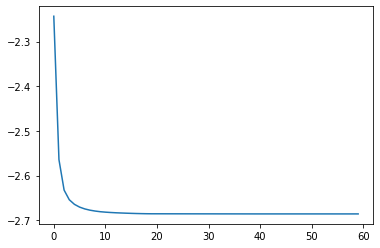

auc =  0.5903460108522489
Loading  5


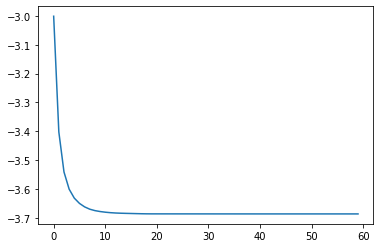

auc =  0.5704745593978388
Loading  6


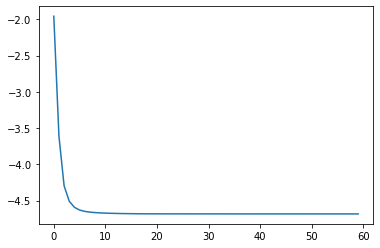

auc =  0.8733561980994283
Loading  7


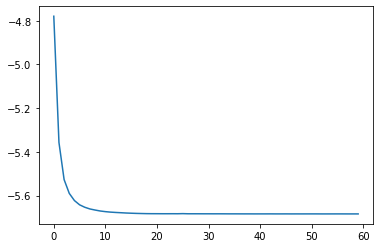

auc =  0.7024120979059798
Loading  8


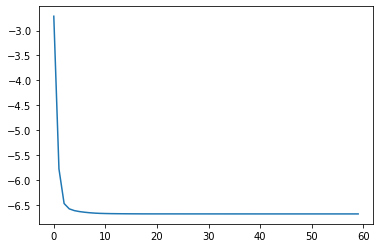

auc =  0.6459194883501053
Loading  9


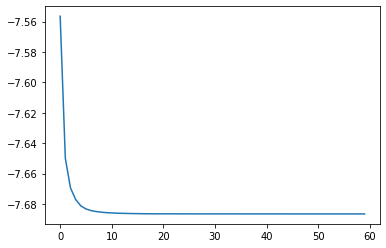

auc =  0.8022830671217412


In [21]:
nu = 0.0
outlier_nu = 0.
lr_milestone = 20
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali= split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae( 10, train_dataset)
    encoder = ae.encoder
    make_binary = make_binary_model(encoder)
    binary_model = make_binary.make_model() 
    classfication = train_classfication(label_num , binary_model, train_dataset, nu )
    classfication.train(lr_milestone)
    test_auc = classfication.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc


In [22]:
result

array([[0.        , 0.        , 0.0514465 , 0.        ],
       [1.        , 0.        , 0.1613028 , 0.        ],
       [2.        , 0.        , 0.7184144 , 0.        ],
       [3.        , 0.        , 0.83010551, 0.        ],
       [4.        , 0.        , 0.59034601, 0.        ],
       [5.        , 0.        , 0.57047456, 0.        ],
       [6.        , 0.        , 0.8733562 , 0.        ],
       [7.        , 0.        , 0.7024121 , 0.        ],
       [8.        , 0.        , 0.64591949, 0.        ],
       [9.        , 0.        , 0.80228307, 0.        ]])

In [23]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

Loading  0


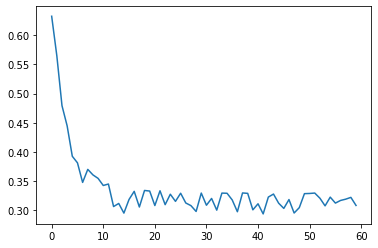

auc =  0.003295850490972447
Loading  1


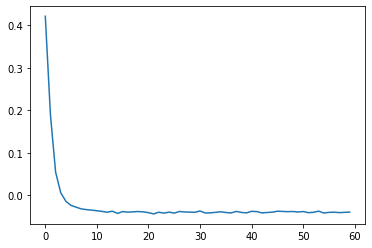

auc =  0.3500158272273033
Loading  2


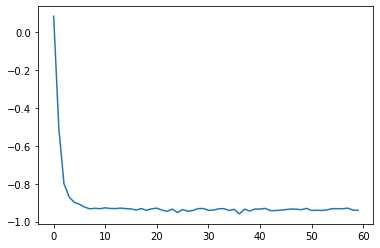

auc =  0.6825589823247515
Loading  3


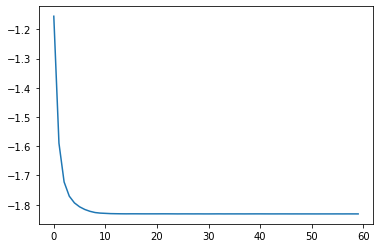

auc =  0.6933468980935913
Loading  4


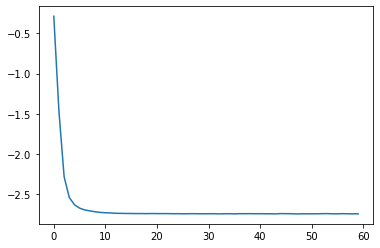

auc =  0.5690420471571002
Loading  5


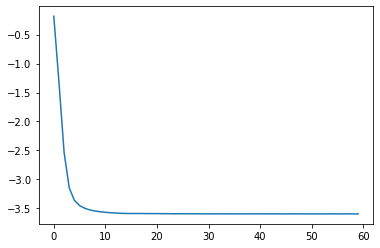

auc =  0.5043315539879197
Loading  6


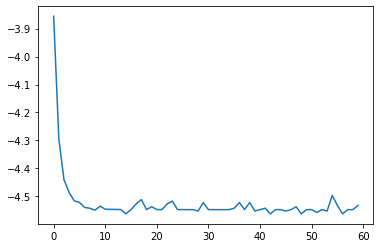

auc =  0.7656927149064052
Loading  7


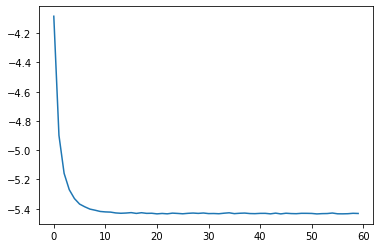

auc =  0.6946765097987513
Loading  8


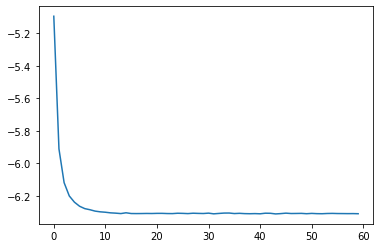

auc =  0.7851325920873807
Loading  9


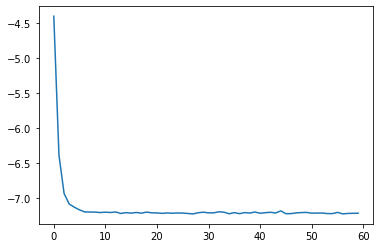

auc =  0.6897065549196372


array([[0.00000000e+00, 0.00000000e+00, 3.29585049e-03, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 3.50015827e-01, 0.00000000e+00],
       [2.00000000e+00, 0.00000000e+00, 6.82558982e-01, 0.00000000e+00],
       [3.00000000e+00, 0.00000000e+00, 6.93346898e-01, 0.00000000e+00],
       [4.00000000e+00, 0.00000000e+00, 5.69042047e-01, 0.00000000e+00],
       [5.00000000e+00, 0.00000000e+00, 5.04331554e-01, 0.00000000e+00],
       [6.00000000e+00, 0.00000000e+00, 7.65692715e-01, 0.00000000e+00],
       [7.00000000e+00, 0.00000000e+00, 6.94676510e-01, 0.00000000e+00],
       [8.00000000e+00, 0.00000000e+00, 7.85132592e-01, 0.00000000e+00],
       [9.00000000e+00, 0.00000000e+00, 6.89706555e-01, 0.00000000e+00]])

In [24]:
nu = 0.1
outlier_nu = 0.1
lr_milestone = 15
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali= split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae( 75, train_dataset)
    encoder = ae.encoder
    make_binary = make_binary_model(encoder)
    binary_model = make_binary.make_model() 
    classfication = train_classfication(label_num , binary_model, train_dataset, nu )
    classfication.train(lr_milestone)
    test_auc = classfication.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc
result

In [25]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

Loading  0


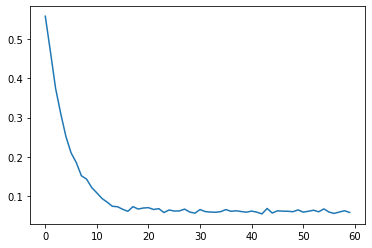

auc =  0.004344879858817142
Loading  1


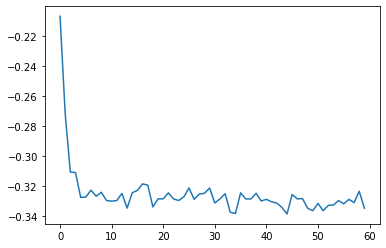

auc =  0.1410117499149007
Loading  2


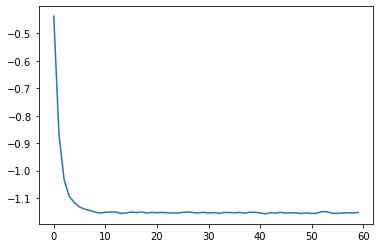

auc =  0.6438692007413093
Loading  3


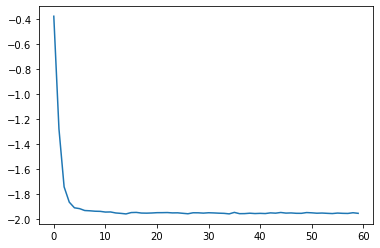

auc =  0.7483519091619952
Loading  4


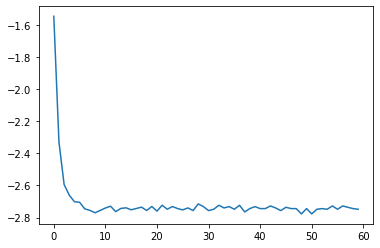

auc =  0.7076213041217858
Loading  5


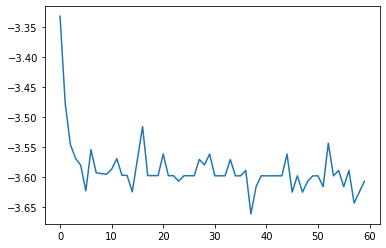

auc =  0.5974775046231471
Loading  6


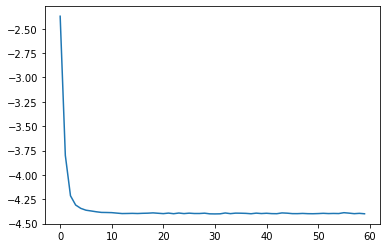

auc =  0.5215268898238284
Loading  7


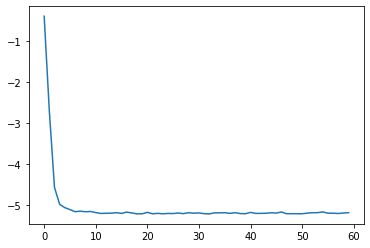

auc =  0.5448566421950869
Loading  8


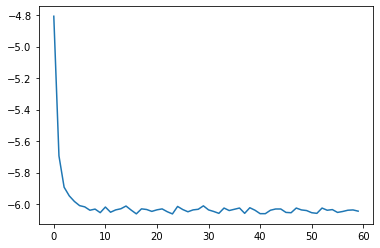

auc =  0.7638086140381131
Loading  9


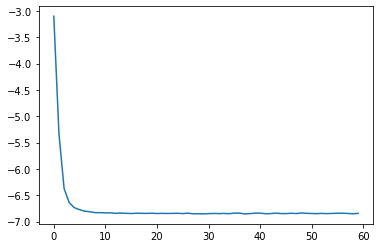

auc =  0.7855557352308812


array([[0.00000000e+00, 0.00000000e+00, 4.34487986e-03, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.41011750e-01, 0.00000000e+00],
       [2.00000000e+00, 0.00000000e+00, 6.43869201e-01, 0.00000000e+00],
       [3.00000000e+00, 0.00000000e+00, 7.48351909e-01, 0.00000000e+00],
       [4.00000000e+00, 0.00000000e+00, 7.07621304e-01, 0.00000000e+00],
       [5.00000000e+00, 0.00000000e+00, 5.97477505e-01, 0.00000000e+00],
       [6.00000000e+00, 0.00000000e+00, 5.21526890e-01, 0.00000000e+00],
       [7.00000000e+00, 0.00000000e+00, 5.44856642e-01, 0.00000000e+00],
       [8.00000000e+00, 0.00000000e+00, 7.63808614e-01, 0.00000000e+00],
       [9.00000000e+00, 0.00000000e+00, 7.85555735e-01, 0.00000000e+00]])

In [26]:
nu = 0.2
outlier_nu = 0.2
lr_milestone = 15
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali= split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae( 75, train_dataset)
    encoder = ae.encoder
    make_binary = make_binary_model(encoder)
    binary_model = make_binary.make_model() 
    classfication = train_classfication(label_num , binary_model, train_dataset, nu )
    classfication.train(lr_milestone)
    test_auc = classfication.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc
result

In [27]:
result = np.zeros((10, 4))
confusionmatrix_train_list = []
confusionmatrix_test_list = []

Loading  0


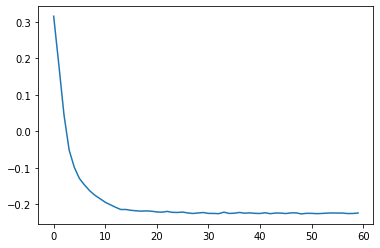

auc =  0.003066654599755649
Loading  1


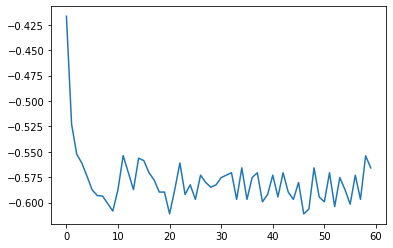

auc =  0.3900050438416681
Loading  2


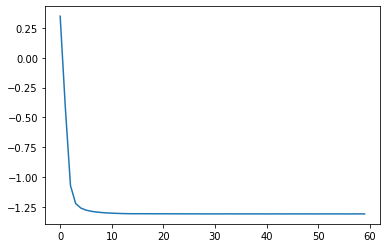

auc =  0.6140095338983051
Loading  3


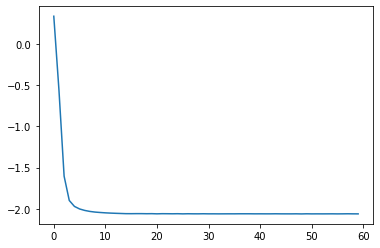

auc =  0.7524983755327701
Loading  4


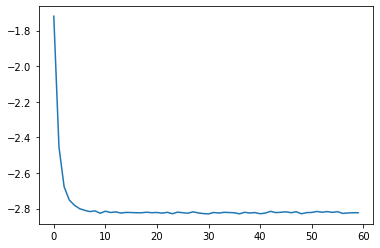

auc =  0.6794200126562896
Loading  5


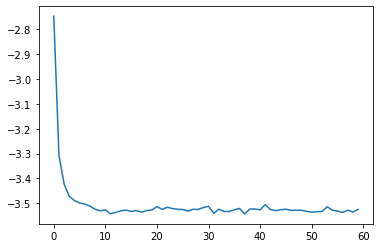

auc =  0.6558349506962784
Loading  6


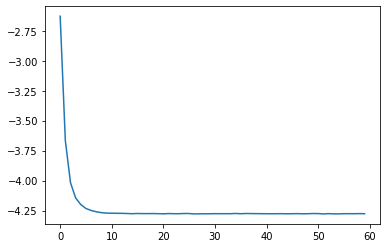

auc =  0.781054741524013
Loading  7


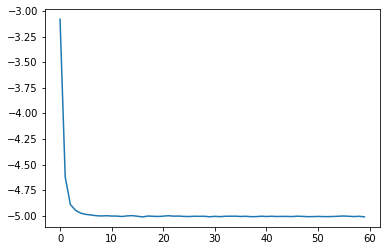

auc =  0.5624228034993434
Loading  8


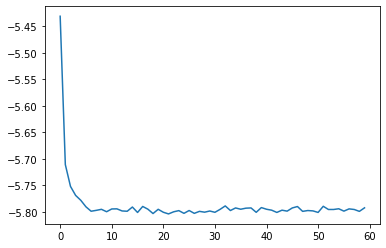

auc =  0.6796769178339918
Loading  9


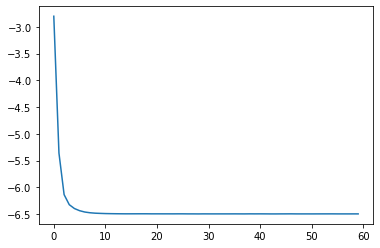

auc =  0.700054971831208


array([[0.00000000e+00, 0.00000000e+00, 3.06665460e-03, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 3.90005044e-01, 0.00000000e+00],
       [2.00000000e+00, 0.00000000e+00, 6.14009534e-01, 0.00000000e+00],
       [3.00000000e+00, 0.00000000e+00, 7.52498376e-01, 0.00000000e+00],
       [4.00000000e+00, 0.00000000e+00, 6.79420013e-01, 0.00000000e+00],
       [5.00000000e+00, 0.00000000e+00, 6.55834951e-01, 0.00000000e+00],
       [6.00000000e+00, 0.00000000e+00, 7.81054742e-01, 0.00000000e+00],
       [7.00000000e+00, 0.00000000e+00, 5.62422803e-01, 0.00000000e+00],
       [8.00000000e+00, 0.00000000e+00, 6.79676918e-01, 0.00000000e+00],
       [9.00000000e+00, 0.00000000e+00, 7.00054972e-01, 0.00000000e+00]])

In [28]:
nu = 0.3
outlier_nu = 0.3
lr_milestone = 15
for label_num in np.arange(10):
    print("Loading ",label_num)
    x_train, y_train, x_test, y_test = load_data(label_num = label_num, outlier_nu = outlier_nu)
    pre_time = time.time()
    train_dataset, x_novali, y_novali, x_vali, y_vali= split_data(x_train, y_train)
    ae = Autoencoder(label_num)
    ae.train_ae( 75, train_dataset)
    encoder = ae.encoder
    make_binary = make_binary_model(encoder)
    binary_model = make_binary.make_model() 
    classfication = train_classfication(label_num , binary_model, train_dataset, nu )
    classfication.train(lr_milestone)
    test_auc = classfication.test_result(x_test, y_test, load_model = True)
    train_time = time.time() - pre_time
    print('auc = ', test_auc)
    result[label_num, 0] = label_num
    result[label_num, 2] = test_auc
result